# Unified Micromagnetic Modeling: Comparison of Calculators

In this Jupyter Notebook we will give an example of a Unified Micromagnetic Modelling (UUM) workflow to compare the output of calculators using Ubermag.

We will use the same example as the previous notebook but run it with both OOMMF and MuMax3 an compare the outputs.
We analyze the data of pre-run simulations to avoid the need to have a GPU. The code needed to create the data can be found at the end of this notebook.
OOMMF files are stored in `oommf_system` and MuMax3 files are stored in `mumax3_system`.

We can use `micromagneticdata` in order to examine previously run data. Let's take a look at the `info` of both systems. We can see that both OOMMF and MuMax3 have two different drives, one for the initial energy minimization and a time driver for running the LLG.

In [5]:
import micromagneticdata as mdata
oommf_data = mdata.Data(name="oommf_system")
oommf_data.info

drive_number        date      time      driver n_threads             t  \
0             0  2023-09-25  16:59:44   MinDriver      None           NaN   
1             1  2023-09-25  16:59:45  TimeDriver      None  2.000000e-10   

       n  
0    NaN  
1  200.0

In [6]:
mumax3_data = mdata.Data(name="mumax3_system")
mumax3_data.info

drive_number        date      time      driver             t      n
0             0  2023-09-25  16:59:49   MinDriver           NaN    NaN
1             1  2023-09-25  17:00:17  TimeDriver  2.000000e-10  200.0

Let's examine the differences in the initial state by subtracting the magnetisation fields from each other just after the minimisation.
We can see the positions of the domain walls are slightly different and have deviations in the magnetisation by up to 10 percent.

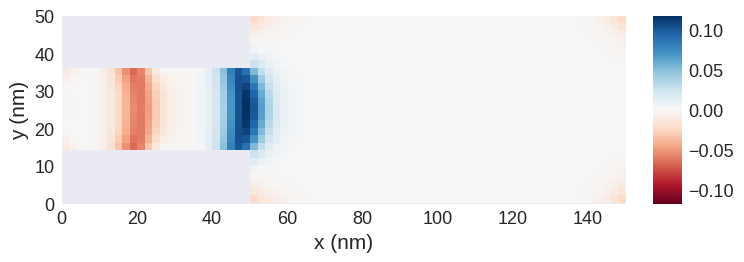

In [7]:
(oommf_data[0][0].orientation - mumax3_data[0][0].orientation).z.sel(z=1e-9).mpl.scalar(symmetric_clim=True, cmap="RdBu")

Now let's look at the differences in the final state after driving with a current.
We can see the positions of the skyrmions are also slightly different and have deviations in the magnetisation by up to 20 percent.

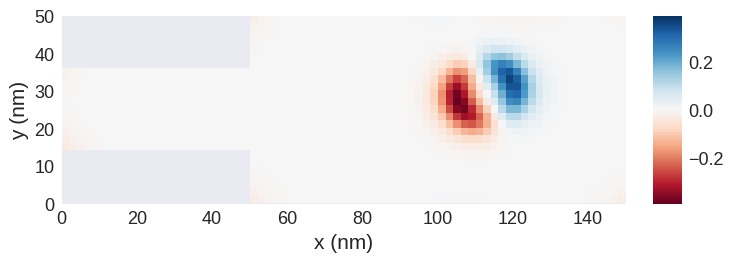

In [8]:
(oommf_data[1][-1].orientation - mumax3_data[1][-1].orientation).z.sel(z=1e-9).mpl.scalar(symmetric_clim=True, cmap="RdBu")

## Creating the data
We have put the data creation from the previous notebook into a function for easy reproducibility. The function takes the `name` of the system and the `calculator` that you wish to use as a backend.

To generate the data we have used:
  - OOMMF 20b0
  - MuMax 3.10

NOTE: We have already created the data as unless you have a GPU and MuMax3 installed then you will not be able to run the MuMax3 cell.

In [1]:
# define micromagnetic problem
import micromagneticmodel as mm
# define geometry and discretisation
import discretisedfield as df

def create_system(name, calculator):
    # define material parameters
    Ms = 5.8e5  # saturation magnetisation (A/m)
    A = 15e-12  # exchange energy constant (J/)
    D = 3e-3  # Dzyaloshinkii-Moriya energy constant (J/m**2)
    K = 0.5e6  # uniaxial anisotropy constant (J/m**3)
    u = (0, 0, 1)  # easy axis
    gamma0 = 2.211e5  # gyromagnetic ratio (m/As)
    alpha = 0.3  # Gilbert damping

    # define Hamiltonian and dynamics
    system = mm.System(name=name)
    system.energy = mm.Exchange(A=A) + mm.DMI(D=D, crystalclass='Cnv_z') + mm.UniaxialAnisotropy(K=K, u=u)
    system.dynamics = mm.Precession(gamma0=2.211e5) + mm.Damping(alpha=alpha)
    
    p1 = (0, 0, 0)                   # corner points of rectangle
    p2 = (150e-9, 50e-9, 2e-9)
    cell = (2e-9, 2e-9, 2e-9)        # discretisation cell size 2nm

    region = df.Region(p1=p1, p2=p2)
    mesh = df.Mesh(region=region, cell=cell)

    # set Ms to zero where there is no magnetic material
    def Ms_fun(pos):
        x, y, z = pos
        if x < 50e-9 and (y < 15e-9 or y > 35e-9):
            return 0
        else:
            return Ms
        
    # define initial magnetisation field 
    def m_init(pos):
        x, y, z = pos
        if 30e-9 < x < 40e-9:
            return (0.1, 0.1, -1)
        else:
            return (0.1, 0.1, 1)

    system.m = df.Field(mesh, nvdim=3, value=m_init, norm=Ms_fun, valid="norm")
    
    md = calculator.MinDriver()
    md.drive(system) 
    
    ux = 400  # velocity in x direction (m/s)
    beta = 0.5  # non-adiabatic STT parameter

    system.dynamics = system.dynamics + mm.ZhangLi(u=ux, beta=beta)
    
    td = calculator.TimeDriver()
    td.drive(system, t=0.2e-9, n=200) 

In [ ]:
import oommfc as oc
create_system('oommf_system', oc)

In [ ]:
import mumax3c as mc
create_system('mumax3_system', mc)